In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as C

CANNY_THRESH = 400
RADIUS_RANGE = (1, 20)
SCAN_STEP = 8
REGEN_TOL = 0.1
VIDEO_FILE = './test_vid.mp4'

# just wrapper to clean up data after hough
hough = lambda img, **kwargs: np.uint16(np.around(C.HoughCircles(img, **kwargs)))

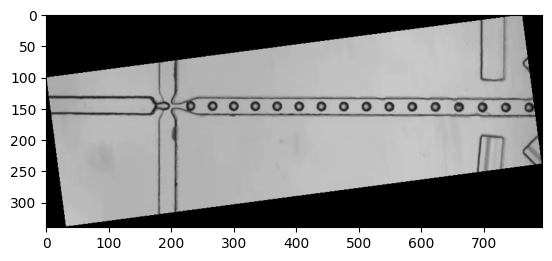

In [2]:
vidcap = C.VideoCapture(VIDEO_FILE)
success, img = vidcap.read()
count = 0
if not success:
  print("Failed to read video")
  exit(1)

plt.imshow(img, cmap='gray')
plt.show()

In [3]:
# img = C.imread(f'./test/001.png', C.IMREAD_GRAYSCALE)
img_orig = img.copy()
edges = C.Canny(img, CANNY_THRESH, CANNY_THRESH)

# Run Hough on preliminary try to get good guesses
detected =  hough(
  edges, method=C.HOUGH_GRADIENT, dp=1,
  minDist=SCAN_STEP, param1 = 100, param2 = 15,
  minRadius = RADIUS_RANGE[0], maxRadius = RADIUS_RANGE[1]
)

# Find which radius wins, and allow for 10% error
unique, counts = np.unique(detected[0, :, 2], return_counts=True)
counts = dict(zip(unique, counts))
R = max(counts, key=counts.get)
E = round(REGEN_TOL * R)

print(f"Using R={R} (seen {max(counts)} times) with ϵ=±{E} => R in ({R-E}, {R+E})")

Using R=7 (seen 15 times) with ϵ=±1 => R in (6, 8)


Mean radius: 7px, Mean distance: 21.7px


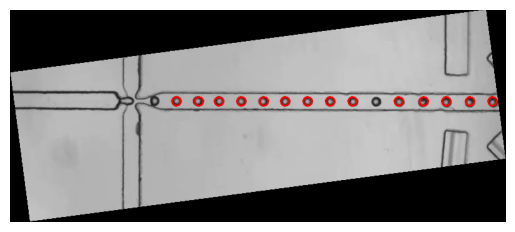

In [4]:
# 2nd round of clean Hough
detected = hough(
  edges, method=C.HOUGH_GRADIENT, dp=1,
  minDist=img.shape[0] / (2 * (R + E)), param1=100, param2=10,
  minRadius=R - E, maxRadius=R + E
)

# Binning 'y's into boxes of size R
detected[0, :, 1] = np.round(detected[0, :, 1] / R) * R
# detected[0, :, 0] = np.round(detected[0, :, 0] / R) * R

# count 'y's
unique, counts = np.unique(detected[0, :, 2], return_counts=True)
counts = dict(zip(unique, counts))

# choose only the mode 'y' and 'R'
max_R = max(counts, key=counts.get)
max_Y = max(detected[0, :, 1])
detected = detected[:, (detected[0, :, 2] == max_R) & (detected[0, :, 1] == max_Y), :]

# sort 'x's
detected = detected[:, detected[0, :, 0].argsort(), :]

# distance between centers in terms of R
# R [X2 - X1 - 2R] ~> ( [X2 - X1] / R ) - 2
diffs = np.round(np.diff(detected[0, :, 0]) / max_R, 1) - 2

# finding mean diff by counting the most common diff
unique, counts = np.unique(diffs, return_counts=True)
counts = dict(zip(unique, counts))
max_diff = max(counts, key=counts.get)

print(f"Mean radius: {max_R}px, Mean distance: {max_diff:.1f}px")

# Draw
for pt in detected[0, :]:
  C.circle(img, (pt[0], pt[1]), pt[2], (255, 0, 0), 2)
plt.imshow(img, cmap='grey')
plt.axis('off')
plt.show()